<a href="https://colab.research.google.com/github/JeromeUwU/Data-Scientist-Project/blob/main/Portfolio_managment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Geometric Brownian Motion Modelisation

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


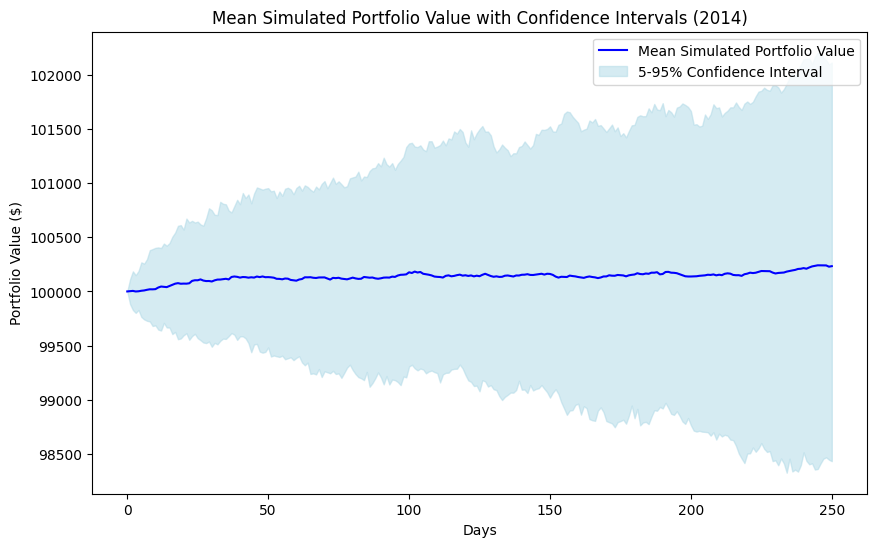

[*********************100%***********************]  2 of 2 completed


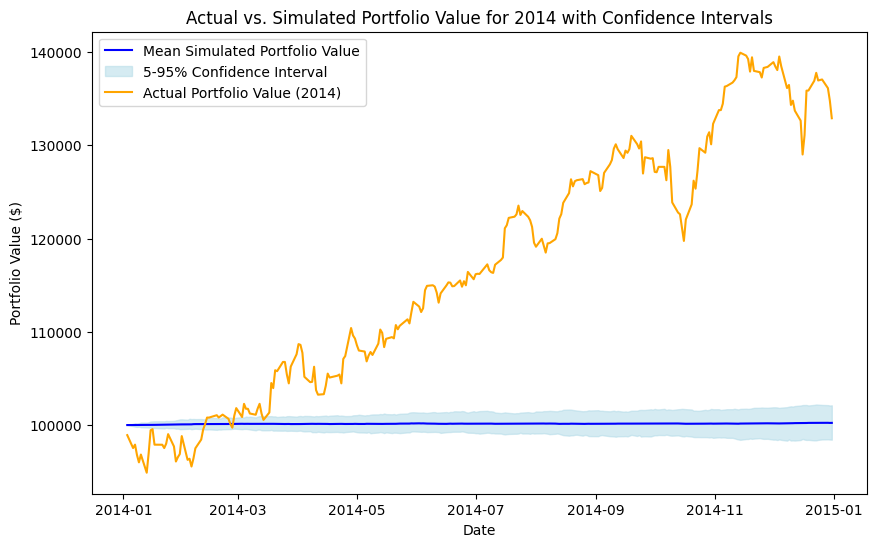

In [100]:
#Import data Apple and Microsoft asset and NASDAQ for Expected return of the market
data = yf.download(['AAPL', 'MSFT', '^IXIC'], start='2012-01-01', end='2013-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()

def Beta(ticker):
    R_i = returns[ticker]
    R_m = returns['^IXIC']
    cov_matrix = np.cov(R_i, R_m)
    covariance = cov_matrix[0, 1]
    variance_market = np.var(R_m)
    beta = covariance / variance_market
    return beta

def Alpha(ticker):
    R_i = returns[ticker]
    R_m = returns['^IXIC']
    alpha = np.mean(R_i) - B_apple * np.mean(R_m)
    return alpha

def CAPM(ticker, beta):
    R_m = np.mean(returns['^IXIC'])

    market_risk_premium = R_m - risk_free_rate

    expected_return = risk_free_rate + beta * market_risk_premium
    return expected_return

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights, cov_matrix):
  return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


B_apple = Beta('AAPL')
B_microsoft = Beta('MSFT')
A_apple = Alpha('AAPL')
A_microsoft = Alpha('MSFT')


#Import data for the U.S. 2-year treasury yield (^TNX) as risk-free proxy
treasury_data = yf.download('^IRX', start='2012-01-01', end='2013-01-01')
risk_free_rate = treasury_data['Adj Close'].iloc[-1] / 100


CAPM_apple = CAPM('AAPL', B_apple)
CAPM_microsoft = CAPM('MSFT', B_microsoft)


vol_AAPL = np.std(returns['AAPL'])
vol_MSFT = np.std(returns['MSFT'])


correlation = np.corrcoef(returns['AAPL'], returns['MSFT'])[0, 1]


expected_returns = np.array([CAPM_apple, CAPM_microsoft])  # (AAPL MSFT) , CAPM expected returns
cov_matrix = returns[['AAPL','MSFT']].cov().to_numpy()  # Covariance matrix


# Using Modern portfolio theory (MPT),
# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each weight (0 to 1, i.e., no short-selling)
bounds = ((0, 1), (0, 1))

# Initial guess (equal weighting)
initial_guess = [0.5, 0.5]

# Minimize portfolio volatility (risk)
optimal_result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = optimal_result.x





weights = optimal_weights
expected_returns = np.array([CAPM_apple, CAPM_microsoft])
volatilities = np.array([vol_AAPL, vol_MSFT])



#Simulation
T = 1  #1 year (2014)
n_days = 251  #Trading days in a year
dt = 1 / n_days  #Time step (1 day)

#Initial prices for AAPL and MSFT (use the last price from 2013 as the initial value for 2014)
initial_prices = np.array([prices['AAPL'].iloc[-1], prices['MSFT'].iloc[-1]])

#Geometric Brownian Motion (GBM)
def simulate_gbm(S0, mu, sigma, T, dt):

    n_steps = int(T / dt)
    prices = np.zeros(n_steps)
    prices[0] = S0
    for t in range(1, n_steps):
        Z = np.random.standard_normal()
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return prices


initial_portfolio_value = 100000


n_simulations = 100
portfolio_simulations = np.zeros((n_simulations, 251))

#Perform multiple simulations
for i in range(n_simulations):

    prices_AAPL_2014 = simulate_gbm(initial_prices[0], expected_returns[0], volatilities[0], T, dt)
    prices_MSFT_2014 = simulate_gbm(initial_prices[1], expected_returns[1], volatilities[1], T, dt)

    #Combine the simulated prices to create the portfolio
    portfolio_prices_2014 = weights[0] * prices_AAPL_2014 + weights[1] * prices_MSFT_2014

    #Normalize to start from $100,000
    portfolio_prices_2014 = initial_portfolio_value * (portfolio_prices_2014 / portfolio_prices_2014[0])


    portfolio_simulations[i, :] = portfolio_prices_2014

#Calculate the mean trajectory across all simulations
mean_portfolio_value = np.mean(portfolio_simulations, axis=0)

#Optionally, calculate confidence intervals (e.g., 5th and 95th percentiles)
lower_bound = np.percentile(portfolio_simulations, 5, axis=0)
upper_bound = np.percentile(portfolio_simulations, 95, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(mean_portfolio_value, label='Mean Simulated Portfolio Value', color='blue')
plt.fill_between(range(251), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='5-95% Confidence Interval')
plt.title('Mean Simulated Portfolio Value with Confidence Intervals (2014)')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Simulating for 2014
data_2014 = yf.download(['AAPL', 'MSFT'], start='2014-01-01', end='2015-01-01')
prices_2014 = data_2014['Adj Close']
returns_2014 = prices_2014.pct_change().dropna()

initial_portfolio_value = 100000
# Actual returns for portfolio configaration based on weights
portfolio_returns_actual = returns_2014.dot(optimal_weights)
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()


mean_portfolio_value_ = pd.DataFrame(mean_portfolio_value, index=portfolio_values_actual.index, columns=['Mean Simulated'])


lower_bound_ = pd.DataFrame(lower_bound, index=portfolio_values_actual.index, columns=['Lower Bound'])
upper_bound_ = pd.DataFrame(upper_bound, index=portfolio_values_actual.index, columns=['Upper Bound'])


plt.figure(figsize=(10, 6))


plt.plot(mean_portfolio_value_, label='Mean Simulated Portfolio Value', color='blue')
plt.fill_between(mean_portfolio_value_.index, lower_bound_['Lower Bound'], upper_bound_['Upper Bound'],
                 color='lightblue', alpha=0.5, label='5-95% Confidence Interval')
plt.plot(portfolio_values_actual, label='Actual Portfolio Value (2014)', linestyle='solid', color='orange')
plt.title('Actual vs. Simulated Portfolio Value for 2014 with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()



# XGB Modelisation

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed

XGBoost RMSE for AAPL: 0.005755544305090972
XGBoost RMSE for MSFT: 0.0031409033268846786


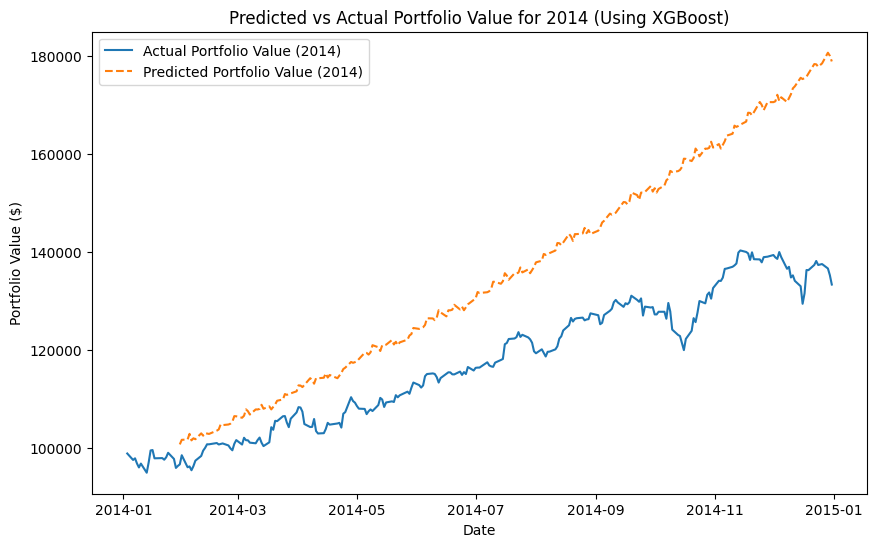

In [107]:
data = yf.download(['AAPL', 'MSFT'], start='2012-01-01', end='2013-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()



weights = np.array([0.5, 0.5])  #Equal weighting for starter

X = returns.shift(1).dropna()  # Use lagged returns as features
y_aapl = returns['AAPL'].shift(-1).dropna()  # Predict next day's return for AAPL
y_msft = returns['MSFT'].shift(-1).dropna()  # Predict next day's return for MSFT


X, y_aapl = X.align(y_aapl, join='inner', axis=0)
_, y_msft = X.align(y_msft, join='inner', axis=0)

# Train the XGBoost models for AAPL and MSFT
xg_reg_aapl = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xg_reg_aapl.fit(X, y_aapl)

xg_reg_msft = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xg_reg_msft.fit(X, y_msft)


predicted_returns_aapl = xg_reg_aapl.predict(X)
predicted_returns_msft = xg_reg_msft.predict(X)



def portfolio_volatility(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)


def optimize_portfolio(predicted_returns, cov_matrix):

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(len(weights))]
    initial_weights = np.array([0.5, 0.5])
    optimal_result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)

    return optimal_result.x

cov_matrix = returns.cov().to_numpy()

# Calculate the predicted covariance matrix for optimization
predicted_cov_matrix = np.cov([predicted_returns_aapl, predicted_returns_msft])
optimal_weights = optimize_portfolio([predicted_returns_aapl, predicted_returns_msft], predicted_cov_matrix)



weights = optimal_weights

portfolio_predicted_returns = optimal_weights[0] * predicted_returns_aapl + optimal_weights[1] * predicted_returns_msft


mse = mean_squared_error(y_aapl, predicted_returns_aapl)
rmse = np.sqrt(mse)
print(f"XGBoost RMSE for AAPL: {rmse}")

mse = mean_squared_error(y_msft, predicted_returns_msft)
rmse = np.sqrt(mse)
print(f"XGBoost RMSE for MSFT: {rmse}")



#Predicting Behaviour for 2014 and Comparing With Actual behaviour
data_2014 = yf.download(['AAPL', 'MSFT'], start='2014-01-01', end='2015-01-01')
prices_2014 = data_2014['Adj Close']
returns_2014 = prices_2014.pct_change().dropna()

weights = optimal_weights  # Use optimized weights
portfolio_returns_actual = returns_2014.dot(weights)  # Actual portfolio returns using optimized weights

initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()


# Using January 2014 data
returns_jan_2014 = returns_2014.loc['2014-01-01':'2014-01-31']
X_jan_2014 = returns_jan_2014.shift(1).dropna()

predicted_returns_aapl_2014 = []
predicted_returns_msft_2014 = []

# Rolling prediction
current_X = X_jan_2014.iloc[-1, :].values.reshape(1, -1)  # Last day's features from January
for i in range(252 - len(X_jan_2014)):

    next_day_return_aapl = xg_reg_aapl.predict(current_X)
    next_day_return_msft = xg_reg_msft.predict(current_X)


    predicted_returns_aapl_2014.append(next_day_return_aapl[0])
    predicted_returns_msft_2014.append(next_day_return_msft[0])

    simulated_next_day_return = np.array([next_day_return_aapl[0], next_day_return_msft[0]])
    current_X = simulated_next_day_return.reshape(1, -1)


predicted_portfolio_returns_2014 = (optimal_weights[0] * np.array(predicted_returns_aapl_2014) +
                                    optimal_weights[1] * np.array(predicted_returns_msft_2014))


predicted_portfolio_values = initial_portfolio_value * (1 + predicted_portfolio_returns_2014).cumprod()


plt.figure(figsize=(10, 6))
plt.plot(returns_2014.index, portfolio_values_actual, label='Actual Portfolio Value (2014)')
plt.plot(returns_2014.index[len(X_jan_2014)-1:], predicted_portfolio_values, label='Predicted Portfolio Value (2014)', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2014 (Using XGBoost)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()



# LSTM Modelisation

In [137]:
EPOCH = 20
BS = 8

In [138]:
data = yf.download(['AAPL', 'MSFT'], start='2012-01-01', end='2013-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()


X = returns.shift(1).dropna().to_numpy()
y = returns.shift(-1).dropna().to_numpy()

# Align X and y to handle any NaNs
X, y = X[1:], y[1:]  # Remove the first element due to alignment


X = X.reshape(X.shape[0], 1, X.shape[1])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(X, y, epochs=EPOCH, batch_size=BS, validation_split=0.1, verbose=1)


predicted_returns = model.predict(X)

# Step 6: Optimize portfolio weights based on predicted returns
def portfolio_volatility(weights, cov_matrix):
    """Calculate the portfolio volatility (standard deviation)."""
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

def optimize_portfolio(predicted_returns, cov_matrix):
    """Optimize portfolio weights to minimize volatility."""
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(2)]  # Two weights for AAPL and MSFT
    initial_weights = np.array([0.5, 0.5])

    # Perform the optimization
    optimal_result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                              method='SLSQP', bounds=bounds, constraints=constraints)

    return optimal_result.x


predicted_cov_matrix = np.cov(predicted_returns[:, 0], predicted_returns[:, 1])
optimal_weights = optimize_portfolio(predicted_returns, predicted_cov_matrix)


predicted_portfolio_returns = optimal_weights[0] * predicted_returns[:, 0] + optimal_weights[1] * predicted_returns[:, 1]


mse_aapl = mean_squared_error(y[:, 0], predicted_returns[:, 0])
rmse_aapl = np.sqrt(mse_aapl)
print(f"LSTM RMSE for AAPL: {rmse_aapl}")

mse_msft = mean_squared_error(y[:, 1], predicted_returns[:, 1])
rmse_msft = np.sqrt(mse_msft)
print(f"LSTM RMSE for MSFT: {rmse_msft}")



[*********************100%***********************]  2 of 2 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.6022e-04 - val_loss: 3.1598e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4831e-04 - val_loss: 3.2071e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6643e-04 - val_loss: 3.2527e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2145e-04 - val_loss: 3.2855e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6598e-04 - val_loss: 3.1028e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4835e-04 - val_loss: 3.1860e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3480e-04 - val_loss: 3.2755e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5610e-04 - val_loss: 3.1475e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7684e-04 - val_loss: 3.1882e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1997e-04 - val_loss: 3.1425e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3623e-04 - v

In [139]:
data = yf.download(['AAPL', 'MSFT'], start='2012-01-01', end='2013-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()


weights = optimal_weights
X = returns.shift(1).dropna().to_numpy()
y = returns.shift(-1).dropna().to_numpy()

# Align X and y to handle any NaNs
X, y = X[1:], y[1:]  # Remove the first element due to alignment


X = X.reshape(X.shape[0], 1, X.shape[1])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mse')

# Step 4: Train the model
history = model.fit(X, y, epochs=EPOCH, batch_size=BS, validation_split=0.1, verbose=1)

[*********************100%***********************]  2 of 2 completed

Epoch 1/20



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.3937e-04 - val_loss: 3.1886e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2837e-04 - val_loss: 3.1972e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8360e-04 - val_loss: 3.1585e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5776e-04 - val_loss: 3.1454e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3241e-04 - val_loss: 3.1899e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9057e-04 - val_loss: 3.1754e-04
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5429e-04 - val_loss: 3.1844e-04
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4027e-04 - val_loss: 3.1061e-04
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5611e-04 - val_loss: 3.1409e-04
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9317e-04 - val_loss: 3.1650e-04
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0916e-04 - val_loss: 3.1186

In [140]:
data_2014 = yf.download(['AAPL', 'MSFT'], start='2014-01-01', end='2015-01-01')
prices_2014 = data_2014['Adj Close']
returns_2014 = prices_2014.pct_change().dropna()


weights = optimal_weights
portfolio_returns_actual = returns_2014.dot(weights)

#Use January 2014 data to initialize the predictions
returns_jan_2014 = returns_2014.loc['2014-01-01':'2014-01-31']
X_jan_2014 = returns_jan_2014.shift(1).dropna()  # Use lagged returns as features
timestep = X_jan_2014.index
X_jan_2014 = X_jan_2014.to_numpy().reshape(X_jan_2014.shape[0], 1, X_jan_2014.shape[1])  # Reshape for LSTM input


predicted_returns = []


current_X = X_jan_2014[-1].reshape(1, 1, -1)  # Start with the last day's features from January

for i in range(252 - len(X_jan_2014)):

    # Predict the next day's returns for AAPL and MSFT
    next_day_return = model.predict(current_X)

    # Weighted sum of the predicted returns for AAPL and MSFT
    predicted_portfolio_return = weights[0] * next_day_return[0][0] + weights[1] * next_day_return[0][1]
    predicted_returns.append(predicted_portfolio_return)

    # Update the features for the next day's prediction
    current_X = next_day_return.reshape(1, 1, -1)


initial_portfolio_value = 100000
predicted_portfolio_values = initial_portfolio_value * (1 + np.array(predicted_returns)).cumprod()
actual_portfolio_values = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()


[*********************100%***********************]  2 of 2 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

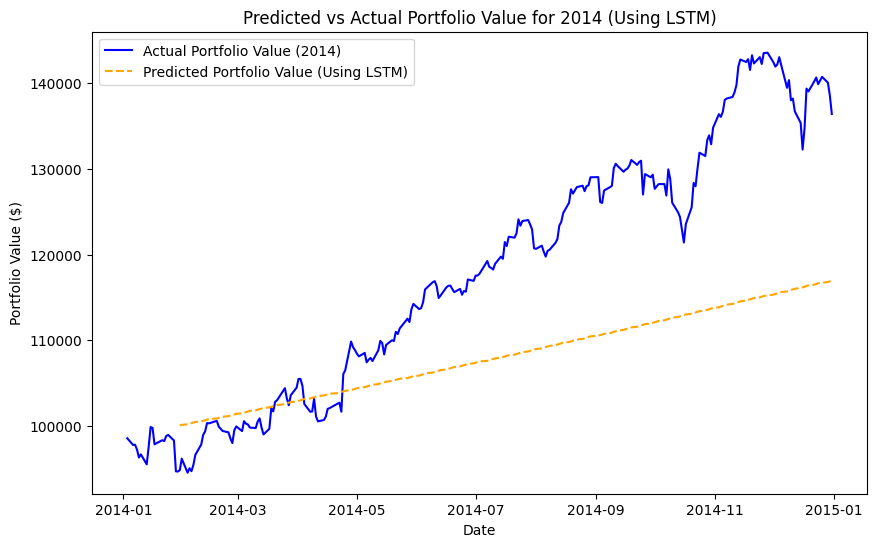

In [141]:
matching_dates = portfolio_returns_actual.index[len(X_jan_2014)-1:len(X_jan_2014) + len(predicted_portfolio_values)]

plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns_actual.index, actual_portfolio_values, label='Actual Portfolio Value (2014)', color='blue')
plt.plot(matching_dates, predicted_portfolio_values, label='Predicted Portfolio Value (Using LSTM)', linestyle='dashed', color='orange')
plt.title('Predicted vs Actual Portfolio Value for 2014 (Using LSTM)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()